开始计算年度指标...


/tmp/ipykernel_5699/2274774058.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2024-07-01", end="2025-07-01")['Close']
[*********************100%***********************]  1 of 1 completed


检查是否为新的季度
DataFrame
计算关键指标
年化收益率

一年期投资结果:
年化收益率: 17.19%
最大回撤: 22.77%
夏普比率: 0.56
最终投资组合价值: $140,630.24


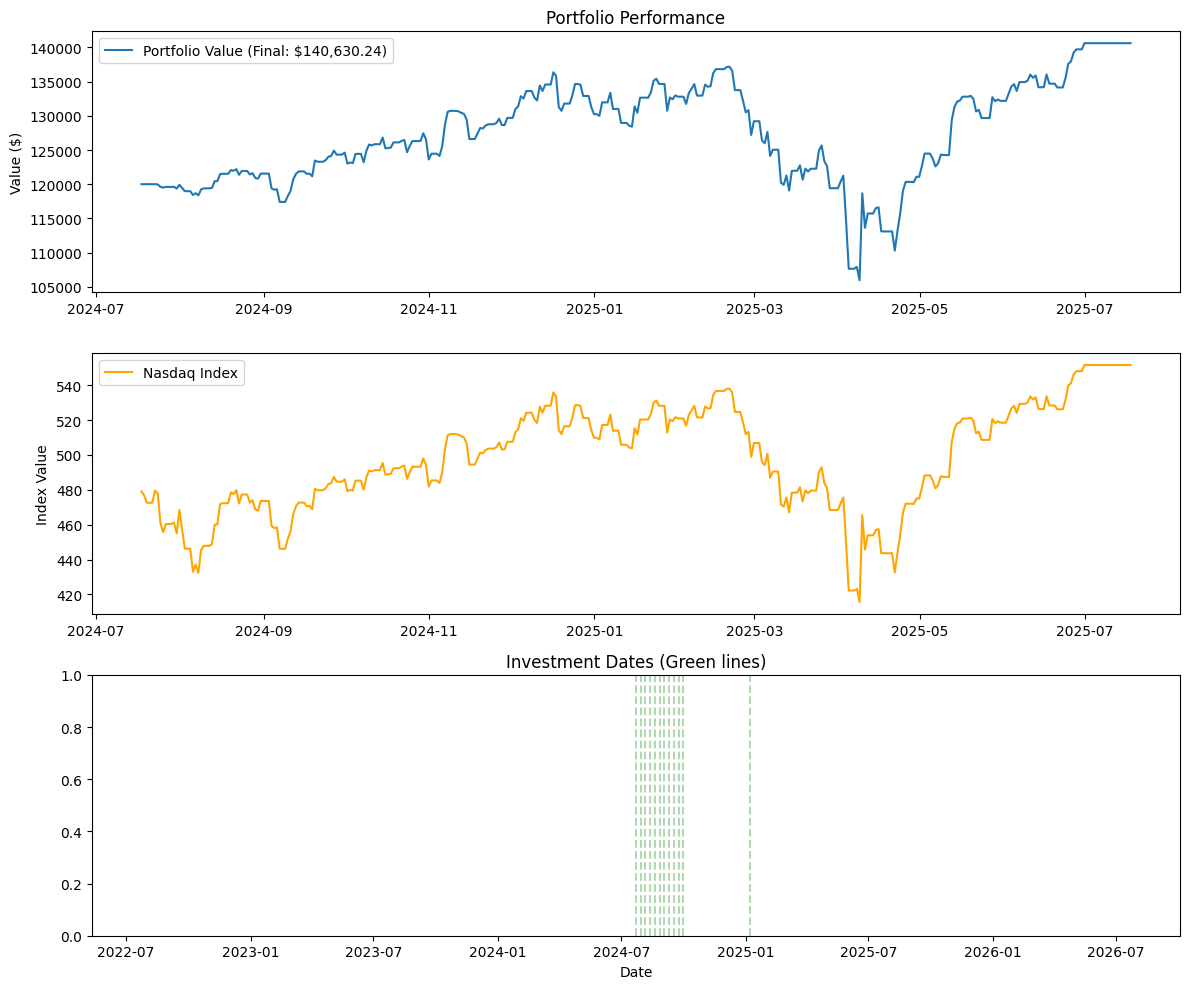

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 先计算一年的数据
def calculate_yearly_metrics(ticker='QQQ', initial_capital=120000, 
                           weekly_investment=10000, years=1):
    """
    计算一年的投资绩效指标
    
    参数:
    ticker: 股票代码
    initial_capital: 初始本金
    weekly_investment: 每周定投金额
    years: 回测年数(默认1年)
    
    返回:
    metrics: 包含绩效指标的字典
    portfolio_history: 投资组合历史数据
    """
    try:
        # 获取历史数据
        end_date = datetime.now()
        start_date = end_date - timedelta(days=years*365)
        data = yf.download(ticker, start="2024-07-01", end="2025-07-01")['Close']
        
        if len(data) == 0:
            raise ValueError("无法获取股票数据")
        
        # 初始化投资组合
        cash = initial_capital
        shares = 0
        total_value = initial_capital
        investment_dates = []
        
        # 创建记录器
        records = []
        
        # 生成所有交易日序列
        all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        quarter = 1  # 当前季度

        print('检查是否为新的季度')
        for current_date in all_dates:
            # 检查是否为新的季度
            if current_date.month in [1, 4, 7, 10] and current_date.day <= 7:
                quarter = (current_date.month - 1) // 3 + 1
            
            # 投资逻辑
            invest_today = False
            if quarter in [1, 3] and current_date.weekday() == 0:  # 第1、3季度的周一
                if cash >= weekly_investment:
                    invest_today = True
                    if quarter == 1:
                        investment_dates.append(current_date)  # 记录第一季度投资日期
            
            if invest_today:
                # 获取当日价格 - 确保获取的是标量值
                try:
                    price = data.asof(current_date)
                    # 确保price是标量值
                    if isinstance(price, pd.Series):
                        price = price.iloc[0] if len(price) > 0 else 0
                    elif pd.isna(price):
                        valid_prices = data[data.index <= current_date]
                        price = valid_prices.iloc[-1] if len(valid_prices) > 0 else 0
                except Exception as e:
                    print(f"获取价格时出错: {str(e)}")
                    price = 0
                
                if price > 0:
                    shares_bought = weekly_investment / price
                    cash -= weekly_investment
                    shares += shares_bought
            
            # 计算当前组合价值 - 确保获取的是标量值
            try:
                current_price = data.asof(current_date)
                # 确保current_price是标量值
                if isinstance(current_price, pd.Series):
                    current_price = current_price.iloc[0] if len(current_price) > 0 else 0
                elif pd.isna(current_price):
                    valid_prices = data[data.index <= current_date]
                    current_price = valid_prices.iloc[-1] if len(valid_prices) > 0 else 0
            except Exception as e:
                print(f"获取当前价格时出错: {str(e)}")
                current_price = 0
            
            total_value = cash + shares * current_price
            
            # 记录数据
            records.append({
                'date': current_date,
                'portfolio_value': total_value,
                'nasdaq_price': current_price,
                'quarter': quarter,
                'shares': shares,
                'cash': cash
            })

        print('DataFrame')
        # 转换为DataFrame
        portfolio_history = pd.DataFrame(records)
        portfolio_history.set_index('date', inplace=True)

        print('计算关键指标')
        # 计算关键指标
        returns = portfolio_history['portfolio_value'].pct_change().dropna()

        print('年化收益率')
        # 年化收益率
        total_return = (portfolio_history['portfolio_value'].iloc[-1] / 
                       portfolio_history['portfolio_value'].iloc[0]) - 1
        annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
        
        # 最大回撤
        peak = portfolio_history['portfolio_value'].cummax()
        drawdown = (portfolio_history['portfolio_value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 夏普比率(假设无风险利率2%)
        risk_free_rate = 0.02
        if len(returns) > 1:
            excess_returns = returns - risk_free_rate/252
            sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
        else:
            sharpe_ratio = 0
        
        metrics = {
            'Annual Return': annual_return,
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Final Value': portfolio_history['portfolio_value'].iloc[-1],
            'Investment Dates': investment_dates
        }
        
        return metrics, portfolio_history
    
    except Exception as e:
        print(f"计算年度指标时出错: {str(e)}")
        raise

# 2. 可视化函数
def plot_yearly_results(metrics, portfolio_history):
    """绘制年度投资表现"""
    plt.figure(figsize=(12, 10))
    
    # 投资组合价值
    plt.subplot(3, 1, 1)
    plt.plot(portfolio_history.index, portfolio_history['portfolio_value'], 
             label=f'Portfolio Value (Final: ${metrics["Final Value"]:,.2f})')
    plt.title('Portfolio Performance')
    plt.ylabel('Value ($)')
    plt.legend()
    
    # 纳斯达克指数
    plt.subplot(3, 1, 2)
    plt.plot(portfolio_history.index, portfolio_history['nasdaq_price'], 
             label='Nasdaq Index', color='orange')
    plt.ylabel('Index Value')
    plt.legend()
    
    # 投资日期标记
    plt.subplot(3, 1, 3)
    invest_dates = metrics['Investment Dates']
    if invest_dates:
        for date in invest_dates:
            plt.axvline(x=date, color='green', alpha=0.3, linestyle='--')
    plt.title('Investment Dates (Green lines)')
    plt.xlabel('Date')
    
    plt.tight_layout()
    plt.show()


# 主程序
if __name__ == "__main__":
    print("开始计算年度指标...")
    
    # 先计算并展示一年的结果
    try:
        yearly_metrics, yearly_history = calculate_yearly_metrics()
        print("\n一年期投资结果:")
        print(f"年化收益率: {yearly_metrics['Annual Return']:.2%}")
        print(f"最大回撤: {abs(yearly_metrics['Max Drawdown']):.2%}")
        print(f"夏普比率: {yearly_metrics['Sharpe Ratio']:.2f}")
        print(f"最终投资组合价值: ${yearly_metrics['Final Value']:,.2f}")
        
        plot_yearly_results(yearly_metrics, yearly_history)
        
    except Exception as e:
        print(f"\n程序运行出错: {str(e)}")
        print("建议检查网络连接或股票代码")

运行纳斯达克+标普500双资产策略回测...


/tmp/ipykernel_7890/1793136296.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed



双资产策略绩效 (1年):
资产配置: {'QQQ': 0.5, 'SPY': 0.5}
年化收益率: 10.62%
最大回撤: 20.79%
夏普比率: 0.67
最终组合价值: $138,941.42


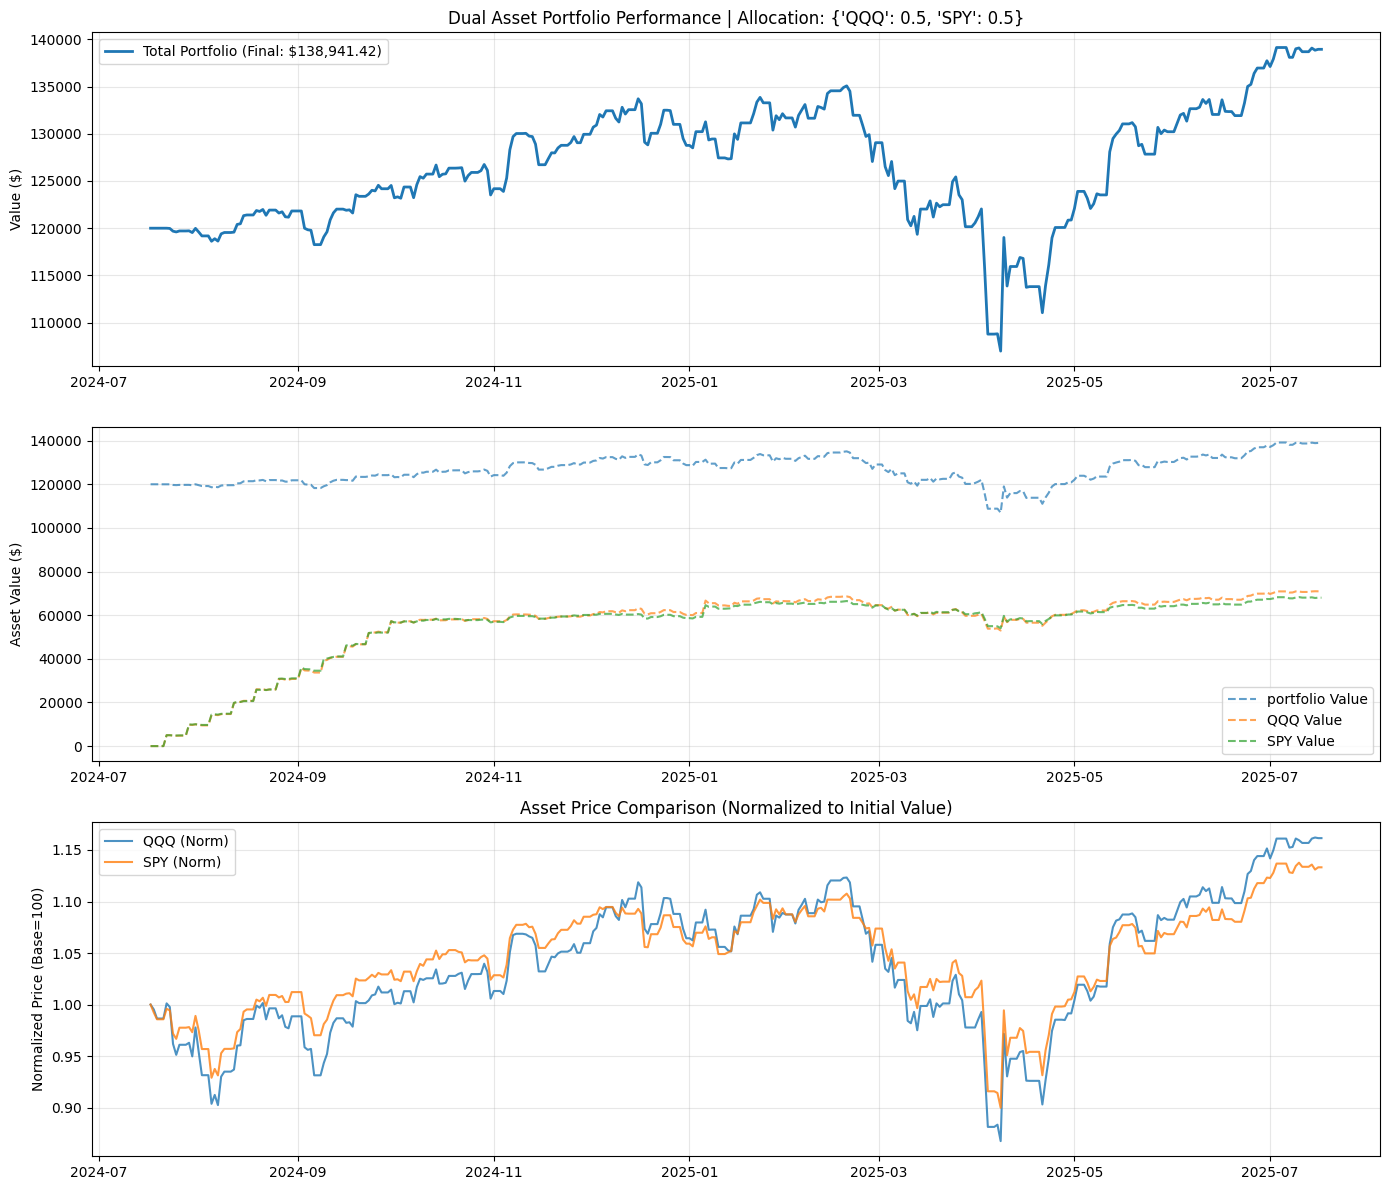

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_price_data(tickers, start_date, end_date):
    """获取多资产价格数据"""
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    if isinstance(tickers, str):  # 如果单资产转换为多资产格式
        data = pd.DataFrame({tickers: data})
    return data.dropna()

def calculate_metrics(portfolio_values, risk_free_rate=0.02):
    """计算绩效指标（兼容多资产）"""
    returns = portfolio_values.pct_change().dropna()
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    years = len(portfolio_values) / 252
    annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
    
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_drawdown = drawdown.min()
    
    if len(returns) > 1:
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
    else:
        sharpe_ratio = 0
    
    return annual_return, max_drawdown, sharpe_ratio

def dual_asset_strategy(tickers=['QQQ', 'SPY'], 
                       initial_capital=120000,
                       weekly_investment=10000,
                       years=1,
                       allocation=[0.5, 0.5]):
    """
    双资产定投策略（纳斯达克+标普500）
    
    参数:
    tickers: 资产代码列表
    initial_capital: 初始本金
    weekly_investment: 每周总定投金额
    years: 回测年数
    allocation: 资产配置比例
    
    返回:
    metrics: 绩效指标字典
    portfolio_history: 投资组合历史数据
    """
    # 获取数据
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    prices = get_price_data(tickers, start_date, end_date)
    
    # 初始化投资组合
    portfolio = {
        'cash': initial_capital,
        'shares': {ticker: 0 for ticker in tickers},
        'total_value': initial_capital,
        'investment_dates': []
    }
    
    records = []
    quarter = 1
    
    for current_date in pd.date_range(start_date, end_date):
        # 季度检测
        if current_date.month in [1, 4, 7, 10] and current_date.day <= 7:
            quarter = (current_date.month - 1) // 3 + 1
        
        # 投资逻辑
        invest_today = (quarter in [1, 3]) and (current_date.weekday() == 0)
        
        if invest_today and portfolio['cash'] >= weekly_investment:
            portfolio['investment_dates'].append(current_date)
            
            # 按比例分配投资金额
            investments = {
                ticker: weekly_investment * alloc 
                for ticker, alloc in zip(tickers, allocation)
            }
            
            for ticker in tickers:
                price = prices[ticker].asof(current_date)
                if not pd.isna(price) and price > 0:
                    shares_bought = investments[ticker] / price
                    portfolio['cash'] -= investments[ticker]
                    portfolio['shares'][ticker] += shares_bought
        
        # 计算当日组合价值
        daily_value = portfolio['cash']
        for ticker in tickers:
            current_price = prices[ticker].asof(current_date)
            if not pd.isna(current_price):
                daily_value += portfolio['shares'][ticker] * current_price
        
        portfolio['total_value'] = daily_value
        
        # 记录数据
        record = {
            'date': current_date,
            'portfolio_value': daily_value,
            'quarter': quarter,
            'cash': portfolio['cash']
        }
        # 添加各资产价值
        for ticker in tickers:
            record[f'{ticker}_value'] = portfolio['shares'][ticker] * prices[ticker].asof(current_date)
            record[f'{ticker}_price'] = prices[ticker].asof(current_date)
        
        records.append(record)
    
    portfolio_history = pd.DataFrame(records)
    portfolio_history.set_index('date', inplace=True)
    
    # 计算绩效指标
    annual_return, max_drawdown, sharpe_ratio = calculate_metrics(portfolio_history['portfolio_value'])
    
    metrics = {
        'Annual Return': annual_return,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Final Value': portfolio_history['portfolio_value'].iloc[-1],
        'Asset Allocation': dict(zip(tickers, allocation)),
        'Investment Dates': portfolio['investment_dates']
    }
    
    return metrics, portfolio_history

def plot_dual_asset_results(metrics, history):
    """绘制双资产结果（修正价格标准化问题）"""
    plt.figure(figsize=(14, 12))
    
    # 组合总价值
    plt.subplot(3, 1, 1)
    plt.plot(history.index, history['portfolio_value'], 
             label=f'Total Portfolio (Final: ${metrics["Final Value"]:,.2f})',
             linewidth=2)
    plt.title(f'Dual Asset Portfolio Performance | Allocation: {metrics["Asset Allocation"]}')
    plt.ylabel('Value ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 各资产价值
    plt.subplot(3, 1, 2)
    assets = [col.replace('_value', '') for col in history.columns if '_value' in col]
    
    for asset in assets:
        if f'{asset}_value' in history.columns:
            plt.plot(history.index, history[f'{asset}_value'], 
                     label=f'{asset} Value', 
                     alpha=0.7,
                     linestyle='--')
    plt.ylabel('Asset Value ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 资产价格标准化比较（修正版）
    plt.subplot(3, 1, 3)
    for asset in assets:
        price_col = f'{asset}_price'
        if price_col in history.columns:
            # 安全标准化处理
            valid_prices = history[price_col].dropna()
            if len(valid_prices) > 0:
                initial_price = valid_prices.iloc[0]
                if initial_price > 0:  # 确保初始价格有效
                    normalized = valid_prices / initial_price
                    plt.plot(normalized.index, normalized,
                             label=f'{asset} (Norm)',
                             alpha=0.8)
                else:
                    print(f"警告: {asset} 初始价格为0，跳过标准化")
            else:
                print(f"警告: {asset} 无有效价格数据")
    
    plt.ylabel('Normalized Price (Base=100)')
    plt.title('Asset Price Comparison (Normalized to Initial Value)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 运行回测
if __name__ == "__main__":
    print("运行纳斯达克+标普500双资产策略回测...")
    
    try:
        # 配置参数
        tickers = ['QQQ', 'SPY']  # 纳斯达克和标普500
        allocation = [0.5, 0.5]       # 各50%配置
        
        metrics, history = dual_asset_strategy(
            tickers=tickers,
            initial_capital=120000,
            weekly_investment=10000,
            years=1,
            allocation=allocation
        )
        
        # 打印结果
        print("\n双资产策略绩效 (1年):")
        print(f"资产配置: {metrics['Asset Allocation']}")
        print(f"年化收益率: {metrics['Annual Return']:.2%}")
        print(f"最大回撤: {abs(metrics['Max Drawdown']):.2%}")
        print(f"夏普比率: {metrics['Sharpe Ratio']:.2f}")
        print(f"最终组合价值: ${metrics['Final Value']:,.2f}")
        
        # 绘制结果
        plot_dual_asset_results(metrics, history)
        
    except Exception as e:
        print(f"回测失败: {str(e)}")
        print("建议检查：")
        print("1. 网络连接是否正常")
        print("2. 股票代码是否正确（^IXIC=纳斯达克, ^GSPC=标普500）")
        print("3. 尝试减少回测年限（如years=1）")

运行纳斯达克+标普500双资产策略回测...


/tmp/ipykernel_5699/3875013085.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  9 of 9 completed



双资产策略绩效 (1年):
资产配置: {'SPY': 0.2, 'QQQ': 0.12, 'SHY': 0.2, 'GLD': 0.25, 'SOYB': 0.03, 'VNM': 0.03, 'INDA': 0.05, 'BTC-USD': 0.07, '159545.SZ': 0.05}
年化收益率: 15.02%
最大回撤: 8.78%
夏普比率: 1.59
最终组合价值: $147,048.09


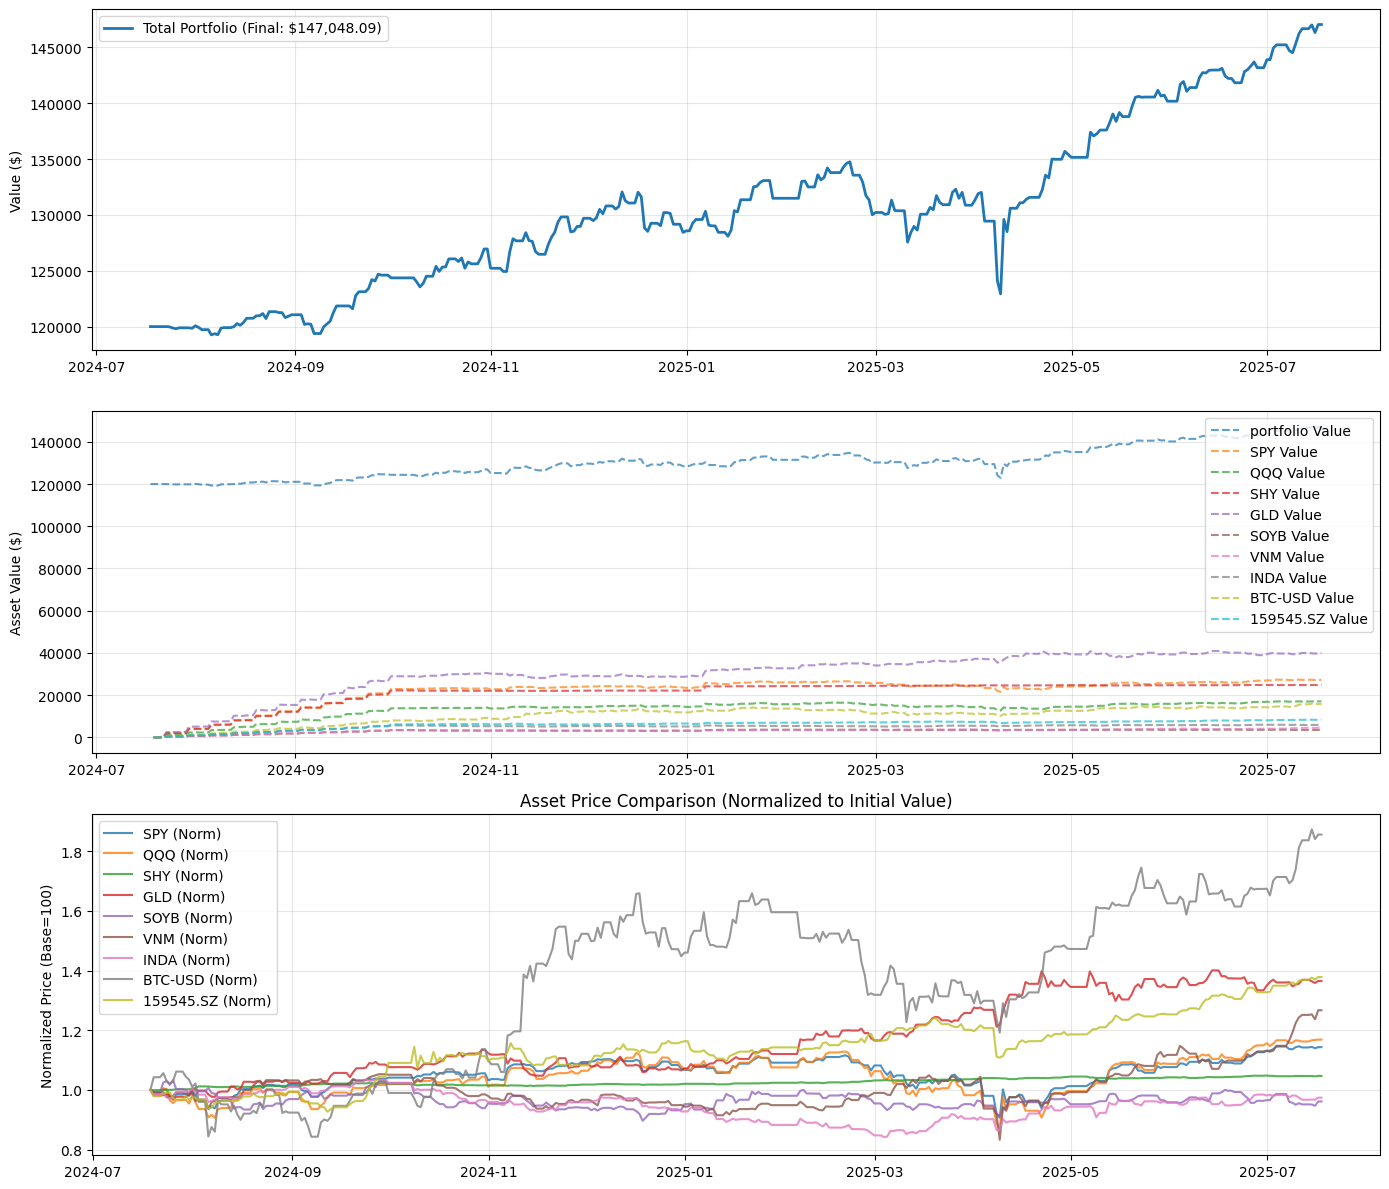

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_price_data(tickers, start_date, end_date):
    """获取多资产价格数据"""
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    if isinstance(tickers, str):  # 如果单资产转换为多资产格式
        data = pd.DataFrame({tickers: data})
    return data.dropna()

def calculate_metrics(portfolio_values, risk_free_rate=0.02):
    """计算绩效指标（兼容多资产）"""
    returns = portfolio_values.pct_change().dropna()
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    years = len(portfolio_values) / 252
    annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
    
    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_drawdown = drawdown.min()
    
    if len(returns) > 1:
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
    else:
        sharpe_ratio = 0
    
    return annual_return, max_drawdown, sharpe_ratio



def dual_asset_strategy(tickers=['QQQ', 'SPY'], 
                       initial_capital=120000,
                       weekly_investment=10000,
                       years=1,
                       allocation=[0.5, 0.5]):
    """
    双资产定投策略（纳斯达克+标普500）
    
    参数:
    tickers: 资产代码列表
    initial_capital: 初始本金
    weekly_investment: 每周总定投金额
    years: 回测年数
    allocation: 资产配置比例
    
    返回:
    metrics: 绩效指标字典
    portfolio_history: 投资组合历史数据
    """
    # 获取数据
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    prices = get_price_data(tickers, start_date, end_date)
    
    # 初始化投资组合
    portfolio = {
        'cash': initial_capital,
        'shares': {ticker: 0 for ticker in tickers},
        'total_value': initial_capital,
        'investment_dates': []
    }
    
    records = []
    quarter = 1
    
    for current_date in pd.date_range(start_date, end_date):
        # 季度检测
        if current_date.month in [1, 4, 7, 10] and current_date.day <= 7:
            quarter = (current_date.month - 1) // 3 + 1
        
        # 投资逻辑
        invest_today = (quarter in [1, 3]) and (current_date.weekday() == 0)
        
        if invest_today and portfolio['cash'] >= weekly_investment:
            portfolio['investment_dates'].append(current_date)
            
            # 按比例分配投资金额
            investments = {
                ticker: weekly_investment * alloc 
                for ticker, alloc in zip(tickers, allocation)
            }
            
            for ticker in tickers:
                price = prices[ticker].asof(current_date)
                if not pd.isna(price) and price > 0:
                    shares_bought = investments[ticker] / price
                    portfolio['cash'] -= investments[ticker]
                    portfolio['shares'][ticker] += shares_bought
        
        # 计算当日组合价值
        daily_value = portfolio['cash']
        for ticker in tickers:
            current_price = prices[ticker].asof(current_date)
            if not pd.isna(current_price):
                daily_value += portfolio['shares'][ticker] * current_price
        
        portfolio['total_value'] = daily_value
        
        # 记录数据
        record = {
            'date': current_date,
            'portfolio_value': daily_value,
            'quarter': quarter,
            'cash': portfolio['cash']
        }
        # 添加各资产价值
        for ticker in tickers:
            record[f'{ticker}_value'] = portfolio['shares'][ticker] * prices[ticker].asof(current_date)
            record[f'{ticker}_price'] = prices[ticker].asof(current_date)
        
        records.append(record)
    
    portfolio_history = pd.DataFrame(records)
    portfolio_history.set_index('date', inplace=True)
    
    # 计算绩效指标
    annual_return, max_drawdown, sharpe_ratio = calculate_metrics(portfolio_history['portfolio_value'])
    
    metrics = {
        'Annual Return': annual_return,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Final Value': portfolio_history['portfolio_value'].iloc[-1],
        'Asset Allocation': dict(zip(tickers, allocation)),
        'Investment Dates': portfolio['investment_dates']
    }
    
    return metrics, portfolio_history

def plot_dual_asset_results(metrics, history):
    """绘制双资产结果（修正价格标准化问题）"""
    plt.figure(figsize=(14, 12))
    
    # 组合总价值
    plt.subplot(3, 1, 1)
    plt.plot(history.index, history['portfolio_value'], 
             label=f'Total Portfolio (Final: ${metrics["Final Value"]:,.2f})',
             linewidth=2)
    # TODO: 不显示TITLE
    # plt.title(f'Dual Asset Portfolio Performance | Allocation: {metrics["Asset Allocation"]}')
    plt.ylabel('Value ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 各资产价值
    plt.subplot(3, 1, 2)
    assets = [col.replace('_value', '') for col in history.columns if '_value' in col]
    
    for asset in assets:
        if f'{asset}_value' in history.columns:
            plt.plot(history.index, history[f'{asset}_value'], 
                     label=f'{asset} Value', 
                     alpha=0.7,
                     linestyle='--')
    plt.ylabel('Asset Value ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 资产价格标准化比较（修正版）
    plt.subplot(3, 1, 3)
    for asset in assets:
        price_col = f'{asset}_price'
        if price_col in history.columns:
            # 安全标准化处理
            valid_prices = history[price_col].dropna()
            if len(valid_prices) > 0:
                initial_price = valid_prices.iloc[0]
                if initial_price > 0:  # 确保初始价格有效
                    normalized = valid_prices / initial_price
                    plt.plot(normalized.index, normalized,
                             label=f'{asset} (Norm)',
                             alpha=0.8)
                else:
                    print(f"警告: {asset} 初始价格为0，跳过标准化")
            else:
                print(f"警告: {asset} 无有效价格数据")
    
    plt.ylabel('Normalized Price (Base=100)')
    plt.title('Asset Price Comparison (Normalized to Initial Value)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 运行回测
if __name__ == "__main__":
    print("运行纳斯达克+标普500双资产策略回测...")
    
    try:
        # 配置参数
        # tickers = ['QQQ', 'SPY']  # 纳斯达克和标普500
        # allocation = [0.5, 0.5]       # 各50%配置

        # weights = {
        #     "SP500": 0.20,
        #     "Nasdaq": 0.12,
        #     "Bonds_short": 0.20,
        #     "Gold": 0.25,
        #     "Cash": 0.00,
        #     "Soybean": 0.03,
        #     "Vietnam": 0.03,
        #     "India": 0.05,
        #     "Bitcoin": 0.07,
        #     "HKHLDB": 0.05
        # }
        # assets = {
        #     "SP500": "SPY",       # 标普500
        #     "Nasdaq": "QQQ",
        #     "Bonds_short": "SHY",
        #     "Bonds_US": "TLT",
        #     "Soybean": "SOYB",    
        #     "US Bonds": "BND",    # 美元债券
        #     "Gold": "GLD",        # 黄金ETF
        #     "Silver": "SLV",      # 白银
        #     "Bitcoin": "BTC-USD", # 比特币
        #     "Vietnam": "VNM",     # 越南ETF
        #     "India": "INDA",      # 印度ETF
        #     "Cash": "SHY",        # 现金（用短期国债替代）
        #     "HKHLDB": "159545.SZ"
        #     # "HLDB": "515450.SH"
        # }

        tickers = ['SPY','QQQ','SHY','GLD','SOYB','VNM','INDA','BTC-USD','159545.SZ'] 
        allocation = [0.20, 0.12, 0.20, 0.25, 0.03, 0.03, 0.05, 0.07, 0.05]      
        
        metrics, history = dual_asset_strategy(
            tickers=tickers,
            initial_capital=120000,
            weekly_investment=10000,
            years=1,
            allocation=allocation
        )
        
        # 打印结果
        print("\n双资产策略绩效 (1年):")
        print(f"资产配置: {metrics['Asset Allocation']}")
        print(f"年化收益率: {metrics['Annual Return']:.2%}")
        print(f"最大回撤: {abs(metrics['Max Drawdown']):.2%}")
        print(f"夏普比率: {metrics['Sharpe Ratio']:.2f}")
        print(f"最终组合价值: ${metrics['Final Value']:,.2f}")
        
        # 绘制结果
        plot_dual_asset_results(metrics, history)
        
    except Exception as e:
        print(f"回测失败: {str(e)}")
        print("建议检查：")
        print("1. 网络连接是否正常")
        print("2. 股票代码是否正确（^IXIC=纳斯达克, ^GSPC=标普500）")
        print("3. 尝试减少回测年限（如years=1）")